In [2]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from collections import Counter
%matplotlib notebook

In [3]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

orig_SR = 44100
orig_blocksize = int(orig_SR * 5)
orig_overlap = 0 #int(orig_SR/4)

SR = 16000
blocksize = int(SR * 5)
overlap = 0 #int(SR/4)

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [5]:
dic = pd.read_csv('./train.csv')
# dict({dic["fname"]:dic["label"]})
class_map_train = dic[["fname","label"]]
class_map_train.index = class_map_train["fname"]
class_map_train = class_map_train.drop(["fname"],axis=1)
class_map_train = class_map_train.to_dict()["label"]
class_map_train
dic = pd.read_csv('./test_post_competition.csv')
dic = dic[dic["label"]!="None"]
print(dic.head())
class_map_test = dic[["fname","label"]]
class_map_test.index = class_map_test["fname"]
class_map_test = class_map_test.drop(["fname"],axis=1)
class_map_test = class_map_test.to_dict()["label"]

           fname      label    usage  freesound_id             license
4   00326aa9.wav       Oboe  Private        355125         Attribution
5   0038a046.wav  Bass_drum  Private         90621  Creative Commons 0
8   007759c4.wav  Saxophone  Private         13406  Creative Commons 0
9   008afd93.wav  Saxophone  Private        358962         Attribution
12  00ae03f6.wav      Chime  Private         78203         Attribution


In [6]:
label_map = list(dic["label"].unique())
label_map = {label_map[i]:i for i in range(len(label_map))}

## Loading

In [6]:
import librosa
import numpy as np
import librosa.display
import time 
import gc #（garbage collector）

audio_dir_train = './FSDKaggle2018.audio_train/'
audio_dir_test = './FSDKaggle2018.audio_test/'
path_to_db_train='./FSD_train/'
path_to_db_test = "./FSD_test/"

SR = 16000
overlap = 0 #int(SR/4)

duration = 5
sample_length = 44100 * duration
for dir_path in [audio_dir_test,audio_dir_train]:
    if dir_path==audio_dir_train:
        class_map = class_map_train
    else:
        class_map = class_map_test
    for fileList in os.walk(dir_path):
        count = 0
        for fname in fileList[2]:
            t1 = time.time()
            name = fname[:-4]
            try:
                curr_class = class_map[fname]
                count += 1
                fpath = dir_path + fname
                (samples, rate) = librosa.load(fpath, sr=None, mono=True,  dtype=np.float32)
                if len(samples) > sample_length: # long enough
                    samples = samples[0:sample_length]
                else: # pad blank
                    padding = sample_length - len(samples)
                    offset = padding // 2
                    if len(samples) == 0:
                        samples = np.pad(samples, (offset, sample_length - len(samples) - offset), 'constant')
                    else:
                        while(len(samples)<sample_length):
                            padding = sample_length - len(samples)
                            samples = np.append(samples, samples[0:padding], axis=0)
#                 S = librosa.feature.melspectrogram(y=samples, sr=SR, power=1.0, n_mels=128, fmin=800, fmax=8000)
                S = librosa.feature.melspectrogram(y=samples, sr=SR)
                # previously S_dB = librosa.power_to_db(S,ref=np.max)
                S_dB = librosa.power_to_db(S)
                # add S_dB = S_dB.astype(np.float32)
                S_dB = S_dB.astype(np.float32)

                if dir_path== audio_dir_train:
                    save_dir = path_to_db_train + curr_class +'/'
                else:
                    save_dir = path_to_db_test + curr_class +'/'
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                np.save(save_dir + name + '.npy',S_dB)
                t2 = time.time()
                if count%100 ==0:
                    print(count)
            except:
                pass

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400


## Estimator

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (3,6))
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 4)
        self.conv2 = nn.Conv2d(64, 32, (3,6))
        self.norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 4)
        self.conv3 = nn.Conv2d(32, 32, (3,6))
        self.norm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(960, 41)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(64, 50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [32]:
# load data:
from PIL import Image
import os 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class dataset(Dataset):
    def __init__(self, mode):
        
        if mode=="train":
            root_dir = './FSD_train/'
        else:
            root_dir = './FSD_test/'
        self.data_list = []
        self.label_list = []
        for root, dir, files in os.walk(root_dir):
            for file in files:
                if file.find('.npy')!= -1:
                    self.data_list.append(os.path.join(root, file))
                    if mode == "train":
                        self.label_list.append(label_map[root[12:]])
                    else:
                        self.label_list.append(label_map[root[11:]])
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

        path = self.data_list[index]
        data = np.load(path,allow_pickle = True)
        data = np.expand_dims(data, axis=0)
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label

In [12]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR

model = Net()
print(model)
model = model.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 9473
batchsize = 64

trainset  = dataset("train")
testset  = dataset("test")
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True) 
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(50):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 6), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=41, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)
99483
9473 9473
1600 1600
===========Phase: Val============
Validation Time: 7.6949

===========Phase: Train============
Training Time: 27.72867202758789
Epoch: 24  train_loss: 3.074684477492467
Epoch: 24  train_accuracy: 0.6978817114093959

===========Phase: Val============
Validation Time: 2.4030115604400635
Epoch: 25  val_loss: 3.359300174713135
Epoch: 25  val_accuracy: 0.410625
===========Phase: Train============
Training Time: 27.67886757850647
Epoch: 25  train_loss: 3.0686747403752883
Epoch: 25  train_accuracy: 0.704488255033557

===========Phase: Val============
Validation Time: 2.414149284362793
Epoch: 26  val_loss: 3.3623936367034912
Epoch: 26  val_accuracy: 0.4025
===========Phase: Train============
Training Time: 27.688126802444458
Epoch: 26  train_loss: 3.0606716031196135
Epoch: 26  train_accuracy: 0.7128775167785235

===========Phase: Val============
Validation Time: 2.4128050804138184
Epoch: 27  val_loss: 3.345919523239136
Epoch: 27  val_accuracy: 0.4275
===========Phase: Train============
Training Time: 27.69240164756775
Epoch: 27  train_loss: 3.05611300

KeyboardInterrupt: 

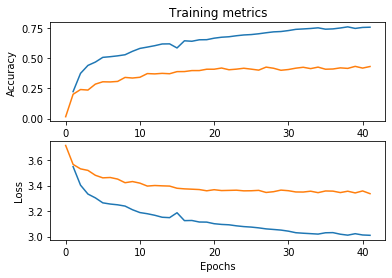

In [13]:
x_axis = np.linspace(1,41,41)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self,):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, (3,6))
        self.norm1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 4)
        self.conv2 = nn.Conv2d(64, 32, (3,6))
        self.norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 4)
        self.conv3 = nn.Conv2d(32, 32, (3,6))
        self.norm3 = nn.BatchNorm2d(32)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(960, 41)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc2 = nn.Linear(64, 50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [33]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

model = Net1()
print(model)
model = model.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

# random_seed= 42
# shuffle_dataset = True
# dataset_size = 9473
# batchsize = 64

# trainset  = dataset("train")
# testset  = dataset("test")
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True) 
# testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)


validation_split = .2
random_seed= 42
shuffle_dataset = True
dataset_size = 9473
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
batch_size = 64
dataset  = dataset("train")
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)



val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(50):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net1(
  (conv1): Conv2d(1, 64, kernel_size=(3, 6), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 6), stride=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=41, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)
99483
9473 9473
===========Phase: Val============
Validation Time: 2.8808746337890

===========Phase: Train============
Training Time: 22.146307706832886
Epoch: 23  train_loss: 3.0714762190810774
Epoch: 23  train_accuracy: 0.6998667521637028

===========Phase: Val============
Validation Time: 2.861598491668701
Epoch: 24  val_loss: 3.18959862391154
Epoch: 24  val_accuracy: 0.5840460518995921
===========Phase: Train============
Training Time: 22.199095010757446
Epoch: 24  train_loss: 3.063138919718125
Epoch: 24  train_accuracy: 0.7076087378654159

===========Phase: Val============
Validation Time: 2.8651392459869385
Epoch: 25  val_loss: 3.184653568267822
Epoch: 25  val_accuracy: 0.5892817974090576
===========Phase: Train============
Training Time: 22.208354949951172
Epoch: 25  train_loss: 3.060719942846218
Epoch: 25  train_accuracy: 0.7107454092562699

===========Phase: Val============
Validation Time: 2.838186740875244
Epoch: 26  val_loss: 3.1931813319524127
Epoch: 26  val_accuracy: 0.5772752185662587
===========Phase: Train============
Training Time: 22.19841623306274

KeyboardInterrupt: 

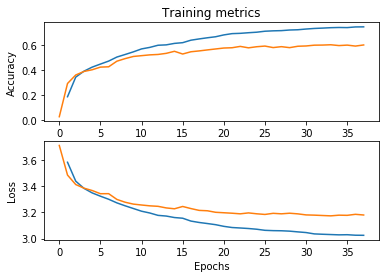

In [34]:
x_axis = np.linspace(1,37,37)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()